# Contents List
01- importing necessary libraries

02- Checking PII

03- Comparing customer behavior in different geographic regions

04- Creating an exclusion flag for low activity customers

05 & 06- Creating a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents

07- Aggregating the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

08- Comparing your customer profiles with regions and departments.

# 01 Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# import the merged dataframe in a memory safe way

table = pq.read_table(
    "orders_customers_combined.parquet",
    memory_map=True
)

In [3]:
df_combined = table.to_pandas(
    split_blocks=True,
    self_destruct=True
)

In [4]:
# quick check on the df
df_combined.head()

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,spending_flag,median_days_of_orders,order_frequency_flag,gender,state,age,date_joined,number_of_dependants,marital_status,income
0,2539329,1,prior,1,2,8,NaN,196,1,0,...,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423
1,2539329,1,prior,1,2,8,NaN,14084,2,0,...,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423
2,2539329,1,prior,1,2,8,NaN,12427,3,0,...,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423
3,2539329,1,prior,1,2,8,NaN,26088,4,0,...,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423
4,2539329,1,prior,1,2,8,NaN,26405,5,0,...,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423


In [5]:
df_combined.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest day',
       'busiest days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'avg_product_price', 'spending_flag', 'median_days_of_orders',
       'order_frequency_flag', 'gender', 'state', 'age', 'date_joined',
       'number_of_dependants', 'marital_status', 'income'],
      dtype='object')

# 02: checking on the personally identifiable information (PII): 
This data frame includes some personal traceable informamtion such as user_id, gender, age or marital_ status. 
Although no direct identifiers (e.g., names or addresses) are included, combining these variables could still enable re-identification. Therefore, the data should be handled securely, with restricted access, and sensitive fields anonymized or aggregated where possible. The 'user_id' should be treated as a pseudonymous identifier, and demographic data should be used only in summarized form.
  

# 03: Compare customer behavior in different geographic areas.
Create a regional segmentation of the data.Determine whether there’s a difference in spending habits between the different U.S.regions

In [6]:
# defining lists of regions 
northeast = ["Connecticut", "Maine", "Massachusetts", "New Hampshire", 
             "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"]

south = ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina","Virginia", 
         "District of Columbia", "West Virginia", "Alabama", "Kentucky","Mississippi", "Tennessee", 
         "Arkansas", "Louisiana", "Oklahoma", "Texas"]

west = ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", 
        "Utah", "Wyoming", "Alaska", "California", "Hawaii", "Oregon", "Washington"]

midwest = ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin","Iowa", "Kansas", "Minnesota", "Missouri", 
           "Nebraska", "North Dakota", "South Dakota"]

In [7]:
# next, the regions are assigned to the states through an if-else loop
def region(state):
    if state in northeast:
        return "Northeast"
    elif state in south:
        return "South"
    elif state in west:
        return "West"
    elif state in midwest:
        return "Midwest"
    else:
        return "Unknown"

In [8]:
# applying the region function to the data frame
df_combined["region"] = df_combined["state"].apply(region) 

In [9]:
# checking the result
df_combined['region'].value_counts()

region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64

In [10]:
#checking the spending habits differences among the U.S states
pd.crosstab(df_combined["region"], df_combined["spending_flag"],dropna=False)

spending_flag,High spender,Low spender
region,,
Midwest,155975,7441350
Northeast,108225,5614511
South,209691,10582194
West,160354,8132559


# 04: Create an exclusion flag for low-activity customers (customers with less than 5 orders) 
and exclude them from the data. Make sure you export this sample.

In [11]:
order_counts = df_combined.groupby("user_id")["order_number"].max().reset_index()

In [12]:
order_counts['low_activity_exclusion'] = order_counts['order_number'] < 5


In [13]:
df_with_exln_flag = df_combined.merge(order_counts[['user_id', 'low_activity_exclusion']] , on="user_id", how="left")

In [14]:
df_with_exln_flag = df_with_exln_flag[df_with_exln_flag["low_activity_exclusion"] == False].copy()

In [15]:
# after excluding low activity customers from the df, I should export this new df
df_with_exln_flag.to_parquet('python_final_df.parquet')

In [34]:
df_with_exln_flag.head(10)

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,gender,state,age,date_joined,number_of_dependants,marital_status,income,region,low_activity_exclusion,customer_profile
0,2539329,1,prior,1,2,8,NaN,196,1,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
1,2539329,1,prior,1,2,8,NaN,14084,2,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
2,2539329,1,prior,1,2,8,NaN,12427,3,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
3,2539329,1,prior,1,2,8,NaN,26088,4,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
4,2539329,1,prior,1,2,8,NaN,26405,5,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
5,2398795,1,prior,2,3,7,15.0,196,1,1,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
6,2398795,1,prior,2,3,7,15.0,10258,2,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
7,2398795,1,prior,2,3,7,15.0,12427,3,1,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
8,2398795,1,prior,2,3,7,15.0,13176,4,0,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent
9,2398795,1,prior,2,3,7,15.0,26088,5,1,...,Female,Alabama,31,2/17/2019,3,married,40423,South,False,Young Parent


In [35]:
df_with_exln_flag.head(10).to_csv("df_head_10.csv", index=False)


In [36]:
df_with_exln_flag.info

<bound method DataFrame.info of           order_id  user_id eval_set  order_number  orders_day_of_week  \
0          2539329        1    prior             1                   2   
1          2539329        1    prior             1                   2   
2          2539329        1    prior             1                   2   
3          2539329        1    prior             1                   2   
4          2539329        1    prior             1                   2   
...            ...      ...      ...           ...                 ...   
32404854   2977660   206209    prior            13                   1   
32404855   2977660   206209    prior            13                   1   
32404856   2977660   206209    prior            13                   1   
32404857   2977660   206209    prior            13                   1   
32404858   2977660   206209    prior            13                   1   

          order_hour_of_day  days_since_prior_order  product_id  \
0           

In [37]:
df_with_exln_flag[["order_id", "user_id"]].nunique()


order_id    3064375
user_id      162631
dtype: int64

In [32]:
df_with_exln_flag.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest day',
       'busiest days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'avg_product_price', 'spending_flag', 'median_days_of_orders',
       'order_frequency_flag', 'gender', 'state', 'age', 'date_joined',
       'number_of_dependants', 'marital_status', 'income', 'region',
       'low_activity_exclusion', 'customer_profile'],
      dtype='object')

# 05-06. Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents.
 You might also use the “orders_day_of_week” and “order_hour_of_day” columns if you can think of a way they would impact customer profiles. (Hint: As an example, try thinking of what characteristics would lead you to the profile “Single adult” or “Young parent.”)

To answe this, I will review some specific columns to see how I can profile customer behavior more effectively.

In [17]:
df_with_exln_flag.filter(['user_id','age', 'income', 'number_of_dependants', 'gender','marital_status',
                          'state','region','department_id', 'orders_day_of_week', 'order_hour_of_day'])

,user_id,age,income,number_of_dependants,gender,marital_status,state,region,department_id,orders_day_of_week,order_hour_of_day
0,1,31,40423,3,Female,married,Alabama,South,7,2,8
1,1,31,40423,3,Female,married,Alabama,South,16,2,8
2,1,31,40423,3,Female,married,Alabama,South,19,2,8
3,1,31,40423,3,Female,married,Alabama,South,19,2,8
4,1,31,40423,3,Female,married,Alabama,South,17,2,8
...,...,...,...,...,...,...,...,...,...,...,...
32404854,206209,74,137969,3,Female,married,Iowa,Midwest,9,1,12
32404855,206209,74,137969,3,Female,married,Iowa,Midwest,19,1,12
32404856,206209,74,137969,3,Female,married,Iowa,Midwest,19,1,12
32404857,206209,74,137969,3,Female,married,Iowa,Midwest,19,1,12


In [ ]:
# to answer this, I will define a customer_profile function and define different categories inside it

df_profile = df_with_exln_flag

conds = [
    (df_profile["age"] < 30) & (df_profile["number_of_dependants"] == 0),
    (df_profile["age"].between(25, 40)) & (df_profile["number_of_dependants"] > 0),
    (df_profile["income"] > 100000) & (df_profile["number_of_dependants"] <= 1),
    (df_profile["income"] < 60000) & (df_profile["number_of_dependants"] >= 2),
    (df_profile["age"] > 60),
]

choices = [
    "Young Adult",
    "Young Parent",
    "Affluent Family",
    "Working_class Family",
    "Old Adult",
]

df_profile["customer_profile"] = np.select(conds, choices, default="Other")

In [24]:
df_profile['customer_profile'].value_counts(dropna=False)

customer_profile
Other                   9041143
Affluent Family         6983337
Old Adult               6058672
Young Parent            5778490
Working_class Family    1655304
Young Adult             1447618
Name: count, dtype: int64

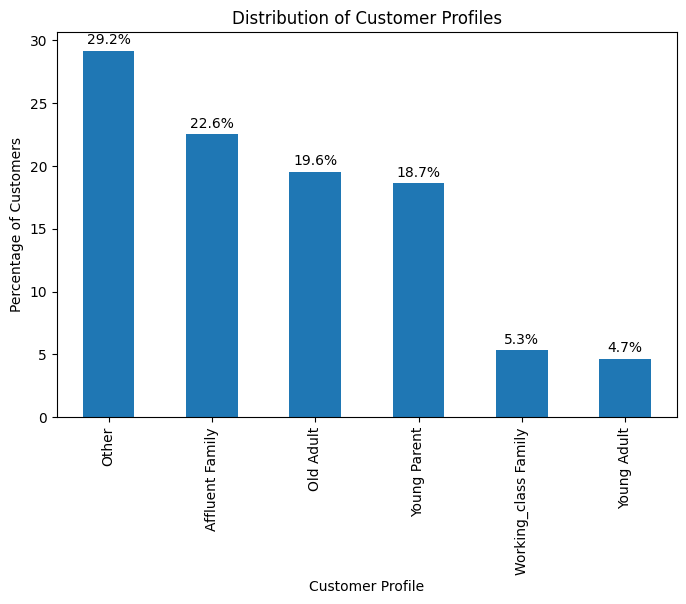

In [ ]:
# Create a bar chart to show distribution

# Calculate percentage distribution
profile_pct = df_profile["customer_profile"].value_counts(normalize=True) * 100

# Plot
ax = profile_pct.plot(kind="bar", figsize=(8, 5), title="Distribution of Customer Profiles")
ax.set_ylabel("Percentage of Customers")
ax.set_xlabel("Customer Profile")

# Add value labels
for idx, value in enumerate(profile_pct):
    ax.text(idx, value + 0.5, f"{value:.1f}%", ha="center")

plt.show()

In [29]:
# export the bar chart
ax.figure.savefig('customer_profile_bar.png')

# 07- Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.


In [38]:
per_user = (
    df_with_exln_flag
    .groupby(
        ["user_id", "customer_profile"],
        as_index=False
    )
    .agg(
        usage_frequency=("order_number", "max"),
        avg_spend=("avg_product_price", "mean")
    )
)


In [39]:
profile_agg = (
    per_user
    .groupby("customer_profile")
    .agg(
        usage_min=("usage_frequency", "min"),
        usage_mean=("usage_frequency", "mean"),
        usage_max=("usage_frequency", "max"),

        spend_min=("avg_spend", "min"),
        spend_mean=("avg_spend", "mean"),
        spend_max=("avg_spend", "max"),
    )
    .reset_index()
)


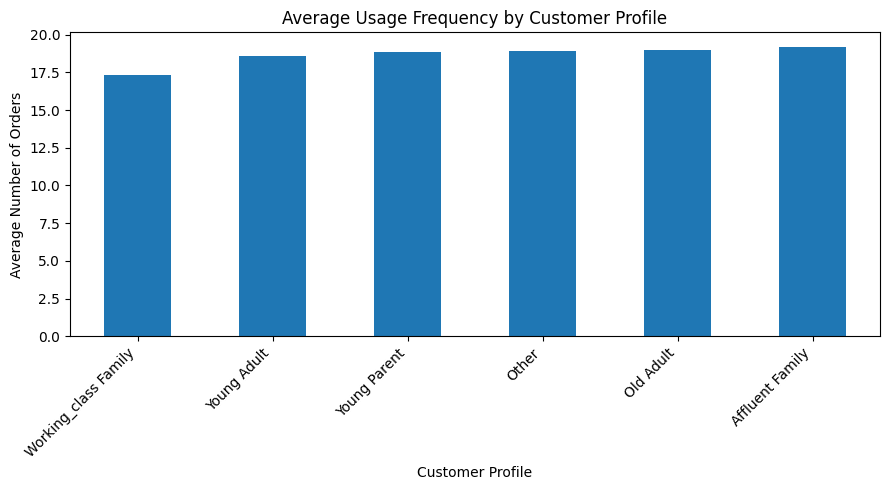

In [40]:
# creating bar chart to illustrate  mean usage freqquency by customer profile

ax_usage = (profile_agg.set_index("customer_profile")["usage_mean"].sort_values().plot(kind="bar", figsize=(9, 5),
        title="Average Usage Frequency by Customer Profile" ))

ax_usage.set_ylabel("Average Number of Orders")
ax_usage.set_xlabel("Customer Profile")
plt.xticks(rotation=45, ha="right")

# Add value labels
for i, v in enumerate(profile_agg.set_index("customer_profile")["usage_mean"].sort_values()):
    ax.text(i, v, f"{v:.1f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [57]:
# exporting the chart
ax_usage.figure.savefig('usage_mean_bar.png')

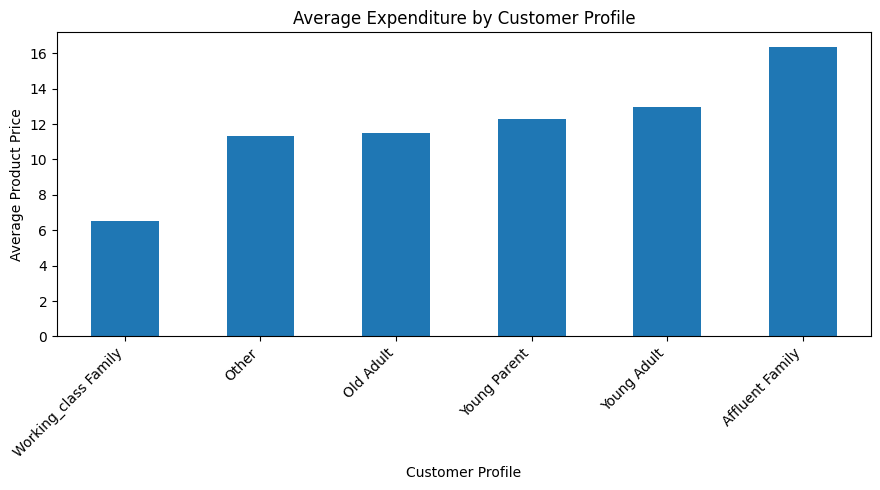

In [41]:
ax_spend = (
    profile_agg
    .set_index("customer_profile")["spend_mean"]
    .sort_values()
    .plot(
        kind="bar",
        figsize=(9, 5),
        title="Average Expenditure by Customer Profile"
    )
)

ax_spend.set_ylabel("Average Product Price")
ax_spend.set_xlabel("Customer Profile")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(profile_agg.set_index("customer_profile")["spend_mean"].sort_values()):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [62]:
# exporting the chart
ax_spend.figure.savefig('spend_mean_bar.png')

In addition to bar charts, boxplots were used to visualize the distribution of usage frequency and expenditure across customer profiles, allowing for a clearer comparison of variability between groups.

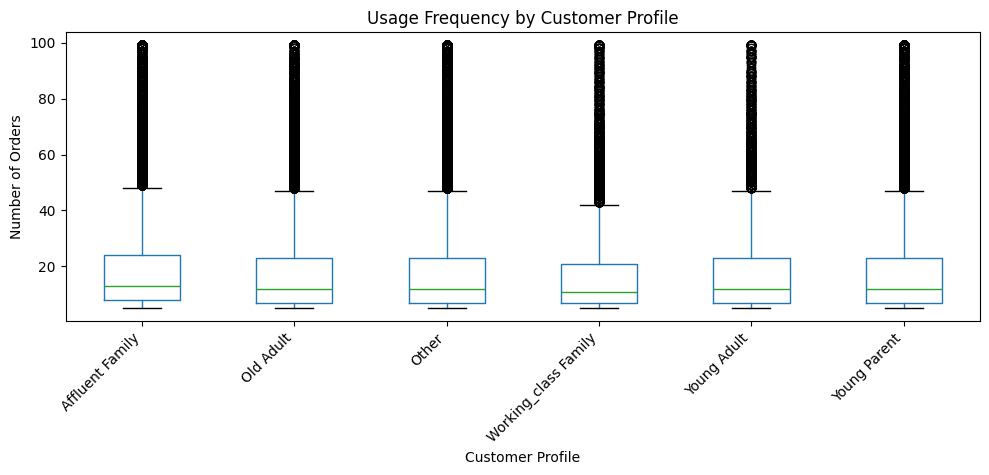

In [43]:
# box plot for mean usage

ax_box_usage = (per_user.boxplot(column="usage_frequency",by="customer_profile",figsize=(10, 5),grid=False))

plt.title("Usage Frequency by Customer Profile")
plt.suptitle("")  # remove automatic subtitle
plt.ylabel("Number of Orders")
plt.xlabel("Customer Profile")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [65]:
# exporting the chart
ax_box_usage.figure.savefig('usage_mean_box.png')

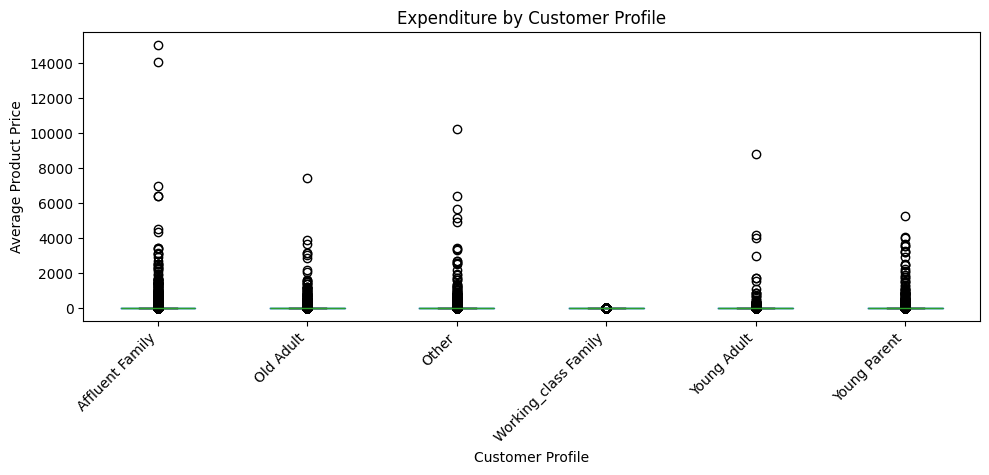

In [45]:
ax_box_spend = (per_user.boxplot(column="avg_spend",by="customer_profile",figsize=(10, 5),grid=False))

plt.title("Expenditure by Customer Profile")
plt.suptitle("")
plt.ylabel("Average Product Price")
plt.xlabel("Customer Profile")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [64]:
# exporting the chart
ax_box_spend.figure.savefig('spend_mean_box.png')

Short description: across customer profiles, expenditure shows strong right-skewness with substantial outliers, particularly among Affluent Family and Other groups, while working-class family customers show more concentrated spending patterns. Usage frequency distributions are more similar across profiles, with comparable medians and spreads, although all groups include a small number of highly active customers with very high order counts.

# 08-Compare your customer profiles with regions and departments.
Can you identify a link between them? 
Customers may demonstrate different behaviors across regions, which could make this information important.

In [ ]:
# profile share per regions
profile_region_dist = (
    df_with_exln_flag
    .groupby(["region", "customer_profile"])["user_id"]
    .nunique()
    .reset_index(name="number_of_customers")
)

profile_region_dist["share_percentage"] = (
    profile_region_dist
    .groupby("region")["number_of_customers"]
    .transform(lambda x: x / x.sum() * 100)
)

profile_region_dist.head()


,region,customer_profile,number_of_customers,share_percentage
0,Midwest,Affluent Family,8260,21.523869
1,Midwest,Old Adult,7395,19.269856
2,Midwest,Other,11150,29.054617
3,Midwest,Working_class Family,2834,7.384824
4,Midwest,Young Adult,1746,4.549719


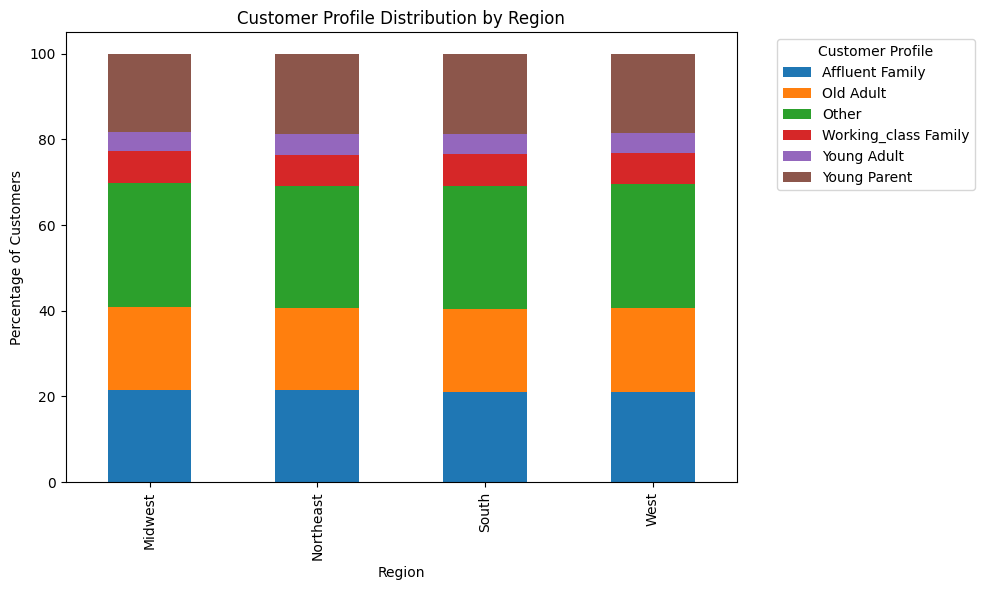

<Figure size 640x480 with 0 Axes>

In [73]:
# stacked bar chart to show distribution
pivot_region = profile_region_dist.pivot(index="region",columns="customer_profile",values="share_percentage")

pivot_region.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    title="Customer Profile Distribution by Region"
)

plt.ylabel("Percentage of Customers")
plt.xlabel("Region")
plt.legend(title="Customer Profile", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# exporting the chart
plt.savefig("region_distribution_stacked_bar.png")

Short description: customer profiles are fairly evenly distributed across regions, indicating broadly consistent customer composition, with only small regional variations in profile prevalence.

In [ ]:
# profile share per departments
profile_department = (
    df_with_exln_flag
    .groupby(["customer_profile", "department_id"])
    .size()
    .reset_index(name="number_of_items")
)


In [52]:
profile_department

,customer_profile,department_id,number_of_items,share_percentage
0,Affluent Family,1,483751,6.927218
1,Affluent Family,2,7739,0.110821
2,Affluent Family,3,260265,3.726943
3,Affluent Family,4,2092963,29.970815
4,Affluent Family,5,34079,0.488005
...,...,...,...,...
121,Young Parent,17,129396,2.239270
122,Young Parent,18,75475,1.306137
123,Young Parent,19,522278,9.038313
124,Young Parent,20,186884,3.234132


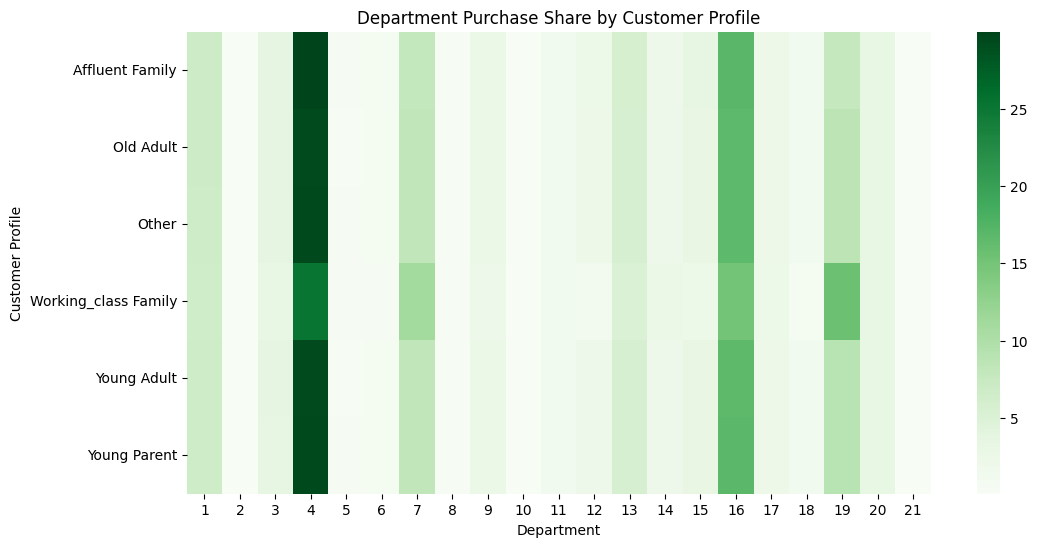

<Figure size 640x480 with 0 Axes>

In [74]:
pivot_dept = profile_department.pivot(index="customer_profile",columns="department_id",values="share_percentage")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_dept, cmap="Greens")

plt.title("Department Purchase Share by Customer Profile")
plt.xlabel("Department")
plt.ylabel("Customer Profile")
#plt.tight_layout()
plt.show()
#exporting the chart
plt.savefig('distribution_dept_heatmap.png')

Results recap: purchases across all customer profiles are strongly concentrated in a small number of departments, particularly Departments 4 and 16, which dominate spending regardless of profile. However, meaningful differences exist in how profiles distribute their purchases. working-class family customers, for example, show a relatively stronger concentration in Department 19, while affluent family, young adult, and young parent profiles display more diversified purchasing patterns. The Other profile exhibits the widest spread across departments, reflecting more heterogeneous consumption behavior.